Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import torch
import torch.optim

from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from utils.inpainting_utils import *

# torch.backends.cudnn.enabled = True
# torch.backends.cudnn.benchmark =True
# dtype = torch.cuda.FloatTensor
dtype = torch.float32

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [2]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
img_path  = 'data/inpainting/kate.png'
mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [3]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [4]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

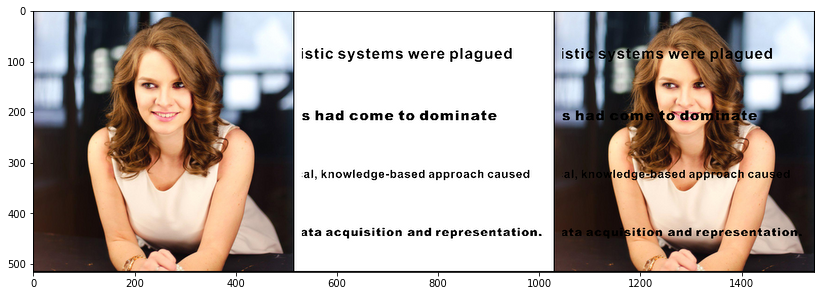

In [5]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [6]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'


In [7]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 3001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

print(net)
net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)


Sequential(
  (1): Concat(
    (0): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace)
      (4): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace)
      (7): Sequential(
        (1): Concat(
          (0): Sequential(
            (

In [ ]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)


# Main loop

In [ ]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);